In [2]:
# 오류가 아니라 경고문을 무시한다.
import warnings
warnings.filterwarnings(action='ignore')

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals
# !pip install tensorflow-gpu==2.0.0-rc1
# !pip install 'h5py' --force-reinstall

In [11]:
import numpy as np

rows = np.loadtxt("../data/lotto.csv", delimiter=",")
row_count = len(rows)
print(row_count)

1007


In [12]:
import numpy as np

# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers2ohbin(numbers):

    ohbin = np.zeros(45) #45개의 빈 칸을 만듬

    for i in range(6): #여섯개의 당첨번호에 대해서 반복함
        ohbin[int(numbers[i])-1] = 1 #로또번호가 1부터 시작하지만 벡터의 인덱스 시작은 0부터 시작하므로 1을 뺌
    
    return ohbin

# 원핫인코딩벡터(ohbin)를 번호로 변환
def ohbin2numbers(ohbin):

    numbers = []
    
    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)
    
    return numbers

In [13]:
numbers = rows[:, 1:7]
ohbins = list(map(numbers2ohbin, numbers))

x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1:row_count]

#원핫인코딩으로 표시
print("ohbins")
print("X[0]: " + str(x_samples[0]))
print("Y[0]: " + str(y_samples[0]))

#번호로 표시
print("numbers")
print("X[0]: " + str(ohbin2numbers(x_samples[0])))
print("Y[0]: " + str(ohbin2numbers(y_samples[0])))

ohbins
X[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
X[0]: [10, 23, 29, 33, 37, 40]
Y[0]: [9, 13, 21, 25, 32, 42]


In [14]:
train_idx = (0, 800)
val_idx = (801, 900)
test_idx = (901, len(x_samples))

print("train: {0}, val: {1}, test: {2}".format(train_idx, val_idx, test_idx))

train: (0, 800), val: (801, 900), test: (901, 1006)


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델을 정의합니다.
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []
    
    for i in range(train_idx[0], train_idx[1]):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys) #배치만큼 모델에 입력하여 나온 답을 정답과 비교함
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))

epoch    0 train acc 0.018 loss 0.408 val acc 0.051 loss 0.399
epoch    1 train acc 0.013 loss 0.396 val acc 0.051 loss 0.398
epoch    2 train acc 0.019 loss 0.394 val acc 0.051 loss 0.398
epoch    3 train acc 0.020 loss 0.392 val acc 0.040 loss 0.399
epoch    4 train acc 0.024 loss 0.388 val acc 0.040 loss 0.401
epoch    5 train acc 0.031 loss 0.382 val acc 0.030 loss 0.404
epoch    6 train acc 0.034 loss 0.376 val acc 0.030 loss 0.407
epoch    7 train acc 0.037 loss 0.370 val acc 0.030 loss 0.410
epoch    8 train acc 0.043 loss 0.364 val acc 0.030 loss 0.413
epoch    9 train acc 0.046 loss 0.357 val acc 0.030 loss 0.417
epoch   10 train acc 0.045 loss 0.351 val acc 0.030 loss 0.422
epoch   11 train acc 0.055 loss 0.343 val acc 0.020 loss 0.427
epoch   12 train acc 0.065 loss 0.335 val acc 0.030 loss 0.432
epoch   13 train acc 0.077 loss 0.326 val acc 0.030 loss 0.438
epoch   14 train acc 0.085 loss 0.317 val acc 0.030 loss 0.444
epoch   15 train acc 0.095 loss 0.308 val acc 0.020 los

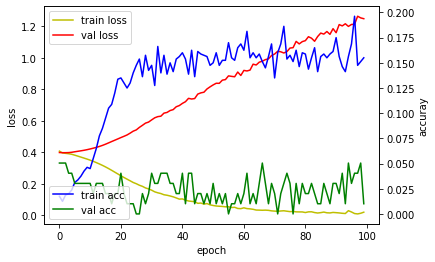

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [19]:
# 88회부터 지금까지 1등부터 5등까지 상금의 평균낸다.
mean_prize = [ np.mean(rows[87:, 8]),
           np.mean(rows[87:, 9]),
           np.mean(rows[87:, 10]),
           np.mean(rows[87:, 11]),
           np.mean(rows[87:, 12])]

print(mean_prize)   

[2434055608.5902176, 57220210.50108696, 1450634.425, 52685.84565217391, 5000.0]


In [20]:
# 등수와 상금을 반환함
# 순위에 오르지 못한 경우에는 등수가 0으로 반환함
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return 0, mean_prize[0]
    elif count == 5 and true_bonus in pred_numbers:
        return 1, mean_prize[1]
    elif count == 5:
        return 2, mean_prize[2]
    elif count == 4:
        return 3, mean_prize[3]
    elif count == 3:
        return 4, mean_prize[4]

    return 5, 0

In [21]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

In [22]:
train_total_reward = []
train_total_grade = np.zeros(6, dtype=int)

val_total_reward = []
val_total_grade = np.zeros(6, dtype=int)

test_total_reward = []
test_total_grade = np.zeros(6, dtype=int)

model.reset_states()

print('[No. ] 1st 2nd 3rd 4th 5th 6th Rewards')

for i in range(len(x_samples)):
    xs = x_samples[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs) # 모델의 출력값을 얻음
    
    sum_reward = 0
    sum_grade = np.zeros(6, dtype=int) # 6등까지 변수

    for n in range(10): # 10판 수행
        numbers = gen_numbers_from_probability(ys_pred[0])
        
        #i회차 입력 후 나온 출력을 i+1회차와 비교함
        grade, reward = calc_reward(rows[i+1,1:7], rows[i+1,7], numbers) 
        
        sum_reward += reward
        sum_grade[grade] += 1

        if i >= train_idx[0] and i < train_idx[1]:
            train_total_grade[grade] += 1
        elif i >= val_idx[0] and i < val_idx[1]:
            val_total_grade[grade] += 1
        elif i >= test_idx[0] and i < test_idx[1]:
            val_total_grade[grade] += 1
    
    if i >= train_idx[0] and i < train_idx[1]:
        train_total_reward.append(sum_reward)
    elif i >= val_idx[0] and i < val_idx[1]:
        val_total_reward.append(sum_reward)
    elif i >= test_idx[0] and i < test_idx[1]:
        test_total_reward.append(sum_reward)
                        
    print('[{0:4d}] {1:3d} {2:3d} {3:3d} {4:3d} {5:3d} {6:3d} {7:15,d}'.format(i+1, sum_grade[0], sum_grade[1], sum_grade[2], sum_grade[3], sum_grade[4], sum_grade[5], int(sum_reward)))

print('Total') 
print('==========')    
print('Train {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(train_total_grade[0], train_total_grade[1], train_total_grade[2], train_total_grade[3], train_total_grade[4], train_total_grade[5], int(sum(train_total_reward))))
print('Val   {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(val_total_grade[0], val_total_grade[1], val_total_grade[2], val_total_grade[3], val_total_grade[4], val_total_grade[5], int(sum(val_total_reward))))
print('Test  {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(test_total_grade[0], test_total_grade[1], test_total_grade[2], test_total_grade[3], test_total_grade[4], test_total_grade[5], int(sum(test_total_reward))))
print('==========')    

[No. ] 1st 2nd 3rd 4th 5th 6th Rewards
[   1]   3   0   4   2   1   0   7,308,079,735
[   2]   1   0   6   3   0   0   2,442,917,472
[   3]   1   0   8   1   0   0   2,445,713,369
[   4]   1   0   7   2   0   0   2,444,315,421
[   5]   3   0   6   1   0   0   7,310,923,318
[   6]   0   0   6   2   2   0       8,819,178
[   7]   3   0   3   3   0   1   7,306,676,786
[   8]   1   0   5   4   0   0   2,441,519,524
[   9]   5   0   5   0   0   0  12,177,531,215
[  10]   6   0   2   1   1   0  14,607,292,606
[  11]   3   1   4   2   0   0   7,365,294,945
[  12]   1   0   3   6   0   0   2,438,723,626
[  13]   4   0   5   1   0   0   9,743,528,292
[  14]   3   0   6   1   0   0   7,310,923,318
[  15]   5   0   3   2   0   0  12,174,735,317
[  16]   2   0   5   3   0   0   4,875,522,446
[  17]   2   0   6   2   0   0   4,876,920,395
[  18]   5   0   5   0   0   0  12,177,531,215
[  19]   4   0   3   2   1   0   9,740,684,709
[  20]   3   0   7   0   0   0   7,312,321,266
[  21]   1   0   6   

[ 180]   2   0   1   7   0   0   4,869,930,652
[ 181]   5   0   4   1   0   0  12,176,133,266
[ 182]   4   0   3   3   0   0   9,740,732,395
[ 183]   3   0   5   1   1   0   7,309,477,683
[ 184]   1   0   6   3   0   0   2,442,917,472
[ 185]   3   0   7   0   0   0   7,312,321,266
[ 186]   2   0   7   1   0   0   4,878,318,344
[ 187]   1   0   5   3   1   0   2,441,471,838
[ 188]   2   0   4   4   0   0   4,874,124,498
[ 189]   1   0   5   4   0   0   2,441,519,524
[ 190]   1   0   8   1   0   0   2,445,713,369
[ 191]   2   0   3   4   1   0   4,872,678,863
[ 192]   1   1   5   2   1   0   2,498,639,362
[ 193]   2   0   6   2   0   0   4,876,920,395
[ 194]   3   0   5   2   0   0   7,309,525,369
[ 195]   5   0   5   0   0   0  12,177,531,215
[ 196]   3   0   6   1   0   0   7,310,923,318
[ 197]   2   0   7   1   0   0   4,878,318,344
[ 198]   2   0   6   2   0   0   4,876,920,395
[ 199]   3   0   6   1   0   0   7,310,923,318
[ 200]   4   0   4   2   0   0   9,742,130,343
[ 201]   1   

[ 358]   1   0   6   2   1   0   2,442,869,786
[ 359]   4   0   5   1   0   0   9,743,528,292
[ 360]   4   0   5   1   0   0   9,743,528,292
[ 361]   7   0   3   0   0   0  17,042,741,163
[ 362]   2   0   4   4   0   0   4,874,124,498
[ 363]   6   0   4   0   0   0  14,610,136,189
[ 364]   3   0   3   3   1   0   7,306,681,786
[ 365]   3   0   6   1   0   0   7,310,923,318
[ 366]   3   0   3   3   1   0   7,306,681,786
[ 367]   1   0   6   3   0   0   2,442,917,472
[ 368]   3   0   6   1   0   0   7,310,923,318
[ 369]   4   0   5   1   0   0   9,743,528,292
[ 370]   4   1   5   0   0   0   9,800,695,816
[ 371]   3   0   4   3   0   0   7,308,127,421
[ 372]   4   0   3   3   0   0   9,740,732,395
[ 373]   2   0   7   1   0   0   4,878,318,344
[ 374]   0   0   8   2   0   0      11,710,447
[ 375]   4   0   4   2   0   0   9,742,130,343
[ 376]   3   0   6   1   0   0   7,310,923,318
[ 377]   1   0   7   2   0   0   2,444,315,421
[ 378]   2   0   6   2   0   0   4,876,920,395
[ 379]   1   

[ 539]   1   0   8   1   0   0   2,445,713,369
[ 540]   1   0   6   2   1   0   2,442,869,786
[ 541]   3   1   3   3   0   0   7,363,896,997
[ 542]   1   0   6   2   1   0   2,442,869,786
[ 543]   2   0   5   2   1   0   4,875,474,760
[ 544]   6   0   4   0   0   0  14,610,136,189
[ 545]   1   0   4   5   0   0   2,440,121,575
[ 546]   4   1   2   2   1   0   9,796,454,285
[ 547]   1   0   5   4   0   0   2,441,519,524
[ 548]   2   0   6   0   1   1   4,876,820,023
[ 549]   5   0   4   0   1   0  12,176,085,580
[ 550]   5   0   4   1   0   0  12,176,133,266
[ 551]   5   0   3   2   0   0  12,174,735,317
[ 552]   4   0   6   0   0   0   9,744,926,240
[ 553]   2   0   6   2   0   0   4,876,920,395
[ 554]   3   1   5   1   0   0   7,366,692,894
[ 555]   5   0   4   1   0   0  12,176,133,266
[ 556]   2   0   3   4   1   0   4,872,678,863
[ 557]   5   0   4   1   0   0  12,176,133,266
[ 558]   6   0   3   1   0   0  14,608,738,240
[ 559]   2   0   8   0   0   0   4,879,716,292
[ 560]   1   

[ 719]   2   0   6   2   0   0   4,876,920,395
[ 720]   2   1   6   1   0   0   4,934,087,920
[ 721]   5   0   2   2   1   0  12,173,289,683
[ 722]   5   0   4   1   0   0  12,176,133,266
[ 723]   5   0   3   2   0   0  12,174,735,317
[ 724]   2   0   5   3   0   0   4,875,522,446
[ 725]   0   0   8   2   0   0      11,710,447
[ 726]   2   0   6   2   0   0   4,876,920,395
[ 727]   0   0   4   4   2   0       6,023,281
[ 728]   4   0   3   2   1   0   9,740,684,709
[ 729]   4   0   5   1   0   0   9,743,528,292
[ 730]   4   0   3   3   0   0   9,740,732,395
[ 731]   0   0   8   2   0   0      11,710,447
[ 732]   4   0   5   1   0   0   9,743,528,292
[ 733]   3   0   6   1   0   0   7,310,923,318
[ 734]   3   0   5   2   0   0   7,309,525,369
[ 735]   2   0   6   2   0   0   4,876,920,395
[ 736]   4   0   4   2   0   0   9,742,130,343
[ 737]   5   0   4   1   0   0  12,176,133,266
[ 738]   7   0   3   0   0   0  17,042,741,163
[ 739]   3   0   6   1   0   0   7,310,923,318
[ 740]   4   

[ 901]   0   0   0   0   0  10               0
[ 902]   0   0   0   0   0  10               0
[ 903]   0   0   0   0   0  10               0
[ 904]   0   0   0   0   0  10               0
[ 905]   0   0   0   0   0  10               0
[ 906]   0   0   0   0   0  10               0
[ 907]   0   0   0   0   0  10               0
[ 908]   0   0   0   0   2   8          10,000
[ 909]   0   0   0   0   0  10               0
[ 910]   0   0   0   0   0  10               0
[ 911]   0   0   0   0   0  10               0
[ 912]   0   0   0   0   0  10               0
[ 913]   0   0   0   0   0  10               0
[ 914]   0   0   0   1   3   6          67,685
[ 915]   0   0   0   0   1   9           5,000
[ 916]   0   0   0   0   0  10               0
[ 917]   0   0   0   0   0  10               0
[ 918]   0   0   0   0   0  10               0
[ 919]   0   0   0   0   0  10               0
[ 920]   0   0   0   0   0  10               0
[ 921]   0   0   0   0   1   9           5,000
[ 922]   0   

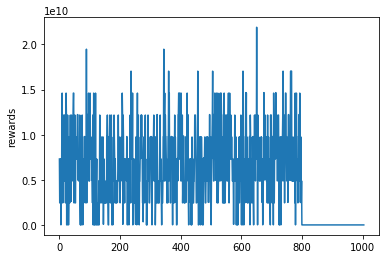

In [24]:
total_reward = train_total_reward + val_total_reward + test_total_reward

plt.plot(total_reward)
plt.ylabel('rewards')
plt.show()

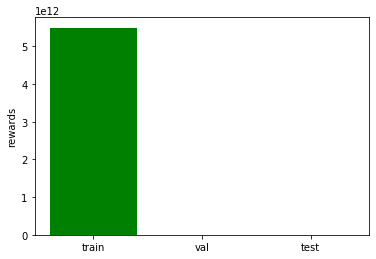

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

rewards = [sum(train_total_reward), sum(val_total_reward), sum(test_total_reward)]

class_color=['green', 'blue', 'red']

plt.bar(['train', 'val', 'test'], rewards, color=class_color)
plt.ylabel('rewards')
plt.show()

In [26]:
# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(x_samples)):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))  

epoch    0 train acc 0.138 loss 0.139
epoch    1 train acc 0.135 loss 0.180
epoch    2 train acc 0.134 loss 0.182
epoch    3 train acc 0.139 loss 0.176
epoch    4 train acc 0.140 loss 0.169
epoch    5 train acc 0.139 loss 0.162
epoch    6 train acc 0.141 loss 0.155
epoch    7 train acc 0.143 loss 0.149
epoch    8 train acc 0.145 loss 0.144
epoch    9 train acc 0.146 loss 0.139
epoch   10 train acc 0.147 loss 0.134
epoch   11 train acc 0.149 loss 0.130
epoch   12 train acc 0.149 loss 0.126
epoch   13 train acc 0.149 loss 0.122
epoch   14 train acc 0.152 loss 0.118
epoch   15 train acc 0.151 loss 0.115
epoch   16 train acc 0.152 loss 0.111
epoch   17 train acc 0.153 loss 0.108
epoch   18 train acc 0.154 loss 0.105
epoch   19 train acc 0.154 loss 0.103
epoch   20 train acc 0.153 loss 0.101
epoch   21 train acc 0.153 loss 0.098
epoch   22 train acc 0.153 loss 0.096
epoch   23 train acc 0.153 loss 0.094
epoch   24 train acc 0.153 loss 0.092
epoch   25 train acc 0.154 loss 0.090
epoch   26 t

In [27]:
# 마지막 회차까지 학습한 모델로 다음 회차 추론

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(10):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)

receive numbers
0 : [2, 10, 13, 18, 36, 41]
1 : [2, 8, 10, 13, 25, 34]
2 : [8, 10, 13, 16, 23, 36]
3 : [2, 8, 10, 13, 34, 36]
4 : [2, 10, 13, 16, 23, 36]
5 : [2, 8, 10, 13, 24, 36]
6 : [2, 8, 10, 23, 34, 36]
7 : [2, 8, 10, 13, 34, 36]
8 : [2, 5, 10, 13, 34, 36]
9 : [2, 10, 13, 25, 36, 41]
